In [1]:
import numpy as np
import brainpy as bp
import brainpy.math as bm
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"  # specify which GPU(s) to be used
bm.disable_gpu_memory_preallocation()
bm.set_platform('gpu')
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

/home/spirit/anaconda3/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Body_Wall_muscle(bp.NeuGroup):
    def __init__(self, size, ECa= 60., gCa= 15.6, EK=-40., gK=34., EL=-26, gL=0.1,
                 V_th= 10., C= 22, p_max = 0.1, phi=1., phi_m = 1.2, gkr = 10., g_slo2 = 10. , g_Na = 0.01, ENa = 30, phi_n = 1.2, noise_factor = 0.01, **kwargs):
        # providing the group "size" information
        super(Body_Wall_muscle, self).__init__(size=size, **kwargs)

        # initialize parameters
        self.ECa = ECa
        self.EK = EK
        self.EL = EL
        self.ENa = ENa
        self.gCa = gCa
        self.g_Na   = g_Na
        self.gK = gK
        self.gL = gL
        self.C = C
        self.p_max = p_max
        self.V_th  = V_th
        self.noise =  noise_factor 
        self.phi_m  = phi_m
        self.phi_n  = phi_n
        self.alpha  = 43.
        self.beta   = 0.09
        self.g_slo2 = g_slo2
        self.gkr    = gkr
        self.phi    = phi
        self.V_shift = 0.

        # initialize variables
        self.V = bm.Variable(bm.random.randn(self.num) - 50.)
        self.m = bm.Variable(0.01 * bm.ones(self.num))
        self.h = bm.Variable(0.6 * bm.ones(self.num))
        self.n = bm.Variable(0.1 * bm.ones(self.num))
        self.p = bm.Variable(0.2 * bm.ones(self.num))
        self.kr = bm.Variable(0.0 * bm.ones(self.num))

        self.p_slo2 = bm.Variable(bm.zeros(self.num))
        self.Ca   = bm.Variable(bm.zeros(self.num))

        self.input = bm.Variable(bm.zeros(self.num))
        self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
        self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

        # integral functions
        self.int_V = bp.odeint(f=self.dV, method='exp_auto')
        self.int_m = bp.odeint(f=self.dm, method='exp_auto')
        self.int_h = bp.odeint(f=self.dh, method='exp_auto')
        self.int_n = bp.odeint(f=self.dn, method='exp_auto')
        self.int_p = bp.odeint(f=self.dp, method='exp_auto')
        self.int_p_slo2 = bp.odeint(f=self.dp_slo2, method='exp_auto')
        self.int_Ca = bp.odeint(f=self.dCa, method='exp_auto')
        self.int_kr = bp.odeint(f=self.dkr, method='exp_auto')

    def dV(self, V, t, m, h, n, p, p_slo2, kr, Iext):
        I_Ca = (self.gCa * m ** 2.0 * h) * (V - self.V_th - self.ECa)
        I_K = (self.gK * n ** 4.0) * (V - self.V_th - self.EK)
        I_M = (self.p_max * p) * (V - self.V_th - self.EK)
        I_slo2 = (self.g_slo2 * p_slo2) * (V -  self.EK)
        I_Na = self.g_Na * (V - self.V_th - self.ENa)
        I_kr = self.gkr *(1-kr) * self.krinf(V) *  (V - self.EK)
        I_leak = self.gL * (V - self.V_th  - self.EL)
        dVdt = (- I_Ca  - I_K - I_Na - I_slo2 - I_leak - I_kr - I_M + Iext) / self.C
        return dVdt
    
    # krinf  = lambda self, V: 0.5 *(1+bm.tanh((V -  self.V_th + 42)/ 5.0))
    krinf  = lambda self, V: 0.5 *(1+bm.tanh((V  - self.V_th + 32)/ 5.0))

    def dkr(self, kr, t, V):
        # krinf = 0.5 *(1+bm.tanh((V -  self.V_th + 42)/ 5.0))
        taumkr= 50
        dkrdt = (self.krinf(V)-kr)/taumkr
        return dkrdt

    def dp_slo2(self, p_slo2, t, Ca, V):
        C2 = self.alpha * bm.power(Ca, 2)
        C3 = C2 + self.beta
        return self.phi * (C2 / C3 - p_slo2) * C3

    def dCa(self, Ca, t, m, h, V):
        ICa = (self.gCa * m ** 2.0 * h) * (V - self.V_th - self.ECa)
        return -0.3 * ICa * 1e-4 - 0.175 * Ca

    def dn(self, n, t, V):
        ninf = 0.5 * (bm.tanh((V - self.V_th +15.2)/36.22)+1)
        tau_n = 1.18+511.78/(1+bm.exp((V - self.V_th + 89.3)/21.92))
        dndt = self.phi_n * (ninf-n)/tau_n
        return dndt

    # def dm(self, m, t, V):
    #     tau_m = 61/(1+bm.exp((V - self.V_th + 81.2)/45.6)) + 22.39/(1+bm.exp(-(V - self.V_th -24.26)/22.26)) - 14.25 
    #     minf = -0.53/(1+bm.exp(-(V - self.V_th - 26)/6.4)) + 1.058/(1+bm.exp(-(V - self.V_th +8.75)/7.2655)) + 0.0095
    #     dmdt = self.phi_m * (minf-m)/tau_m
    #     return dmdt


    def dm(self, m, t, V):
        tau_m = 0.4 + .7 / (bm.exp(-(V + 5. - self.V_shift - self.V_th) / 15.) +
                       bm.exp((V + 5. - self.V_shift - self.V_th) / 15.))
        minf = 1. / (1 + bm.exp(-(V + 8. - self.V_shift - self.V_th) / 8.6))
        dmdt = self.phi_m * (minf-m)/tau_m
        return dmdt

    def dh(self, h, t, V):
        # hinf = 0.435/(1+bm.exp((V  - self.V_th + 10.38)/0.5554)) + 64.045/(1+bm.exp(-(V  - self.V_th -171.5)/30.8)) + 0.1
        hinf   = 0.42 / (1. + bm.exp((V + 11. - self.V_shift - self.V_th) / 2.)) + 0.28
        # hinf  = (1.43 / (1 + bm.exp(-(V - self.V_th + 15 - 14.9) / 12)) + 0.14) * (5.96 / (1 + bm.exp((V  - self.V_th  + 15 + 20.5) / 8.1)) + 0.6 - 0.32)
        tau_h = 30
        dhdt = (hinf-h)/tau_h
        return dhdt

    def dp(self, p, t, V):
        pinf = 1/(1+bm.exp(-(V- self.V_th +45)/10))
        tau_p = 4000/(3.38*bm.exp((V- self.V_th+45)/20)+bm.exp(-(V- self.V_th +45)/20))
        dpdt = (pinf-p)/tau_p
        return dpdt

    def update(self, tdi, x=None):
        _t, _dt = tdi.t, tdi.dt
        # compute V, m, h, n
        noise_add = self.noise * bm.random.randn(self.num) / bm.sqrt(_dt)
        V = self.int_V(self.V, _t, self.m, self.h, self.n, self.p, self.p_slo2, self.kr, self.input/0.75, dt=_dt)
        self.h.value = self.int_h(self.h, _t, self.V, dt=_dt)
        self.m.value = self.int_m(self.m, _t, self.V, dt=_dt)
        self.n.value = self.int_n(self.n, _t, self.V, dt=_dt)
        self.p.value = self.int_p(self.p, _t, self.V, dt=_dt)
        self.p_slo2.value = self.int_p_slo2(self.p_slo2, _t, self.Ca, self.V, dt=_dt)
        self.Ca.value = self.int_Ca(self.Ca, _t, self.m, self.h, self.V, dt=_dt)
        self.kr.value = self.int_kr(self.kr, _t, self.V, dt=_dt)

        # update the spiking state and the last spiking time
        self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
        self.t_last_spike.value = bm.where(self.spike, _t, self.t_last_spike)

        # update V
        self.V.value = V

        # reset the external input
        self.input[:] = 0.

In [19]:
# total_time = 1.5* 1000.  # 总时长 (s)
# start_time = 0.14 * 1000.  # 刺激启始时刻 (s)
# end_time =   1.14 * 1000.  # 刺激结束时刻 (s)
total_time = 4.3* 1000.  # 总时长 (s)
start_time = 0.167 * 1000.  # 刺激启始时刻 (s)
end_time =   2.177 * 1000.  # 刺激结束时刻 (s)

I_current_amplitude   = [30.0 ,25.0, 20.0, 15.0]  # 刺激电流幅值 (nA)
syn_current, duration = bp.inputs.section_input(values=[-20, I_current_amplitude, -20.],
                                             durations=[start_time, end_time - start_time, total_time - end_time],
                                             return_length=True,
                                             dt=0.1)

In [20]:
# gkr = 2.6 # 30.0
# gkr = 3.5 # 25.0

def HHsimulator(duration, I, dt ,params=None, seed=None):
    # neuron = Body_Wall_muscle(size=1, gCa=params[0], gK=params[1], p_max=params[2], ECa= params[3], ENa= 0., g_Na= 0.4, g_slo2 = 3, gkr= 11., phi = 0.04)
    neuron = Body_Wall_muscle(size=1, gCa=params[0], gK=params[1], p_max=params[2], ECa= params[3], ENa= 0., g_Na= 0.4, g_slo2 = 3, gkr= 11., phi = 0.04)
    neuron.V_shift = 0
    neuron.alpha   = 43.
    neuron.beta    = 0.05
    runner = bp.DSRunner(
        neuron, 
        monitors=['spike', 'V','Ca','p_slo2'], 
        inputs=('input', I,'iter'),  # constant external inputs of 22 mA to all neurons
        dt=dt
    )

    runner.run(duration)  # the running time is 200 ms
    V = runner.mon.V
    return np.array(V).reshape(-1, 1), np.array(runner.mon.spike).reshape(-1, 1), np.array(runner.mon.Ca).reshape(-1, 1), np.array(runner.mon.p_slo2).reshape(-1, 1)

aike,_, Ca, p_slo2 = HHsimulator(duration, syn_current[:,0], dt = 0.1, params= [19.2, 37., 0., 60])

  0%|          | 0/43000 [00:00<?, ?it/s]

Predict 43000 steps: : 100%|██████████| 43000/43000 [00:05<00:00, 7614.37it/s] 


In [21]:
data = np.load("spikes.npy")
real_value = data[:,0]

In [22]:
na_free = np.loadtxt('na_free.csv', delimiter=',')

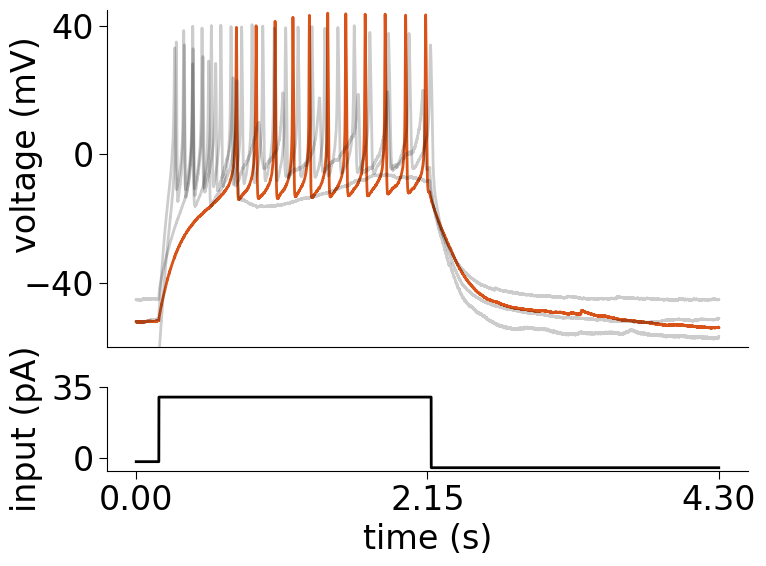

In [23]:
plt_style = {
    'figure.figsize' : (8, 6),
    'figure.autolayout' : True,
    'font.size' : 18,
    'lines.linewidth' : 3,
    'xtick.labelsize' : 24,
    'ytick.labelsize' : 24,
    'legend.fontsize' : 'small',
    'axes.spines.top' : False,
    'axes.spines.right' : False,
    'xtick.major.size' : 6,
    'ytick.major.size' : 6,
    'legend.fontsize' : 14,
    'axes.labelsize' : 24,
    'axes.titlesize' : 24,
    # 'font.family': "Times New Roman"
    }
for key, val in plt_style.items():
    plt.rcParams[key] = val




aike_time = np.linspace(0, 4.3, len(aike))
fig = plt.figure(figsize=(8, 6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
# plt.plot(aike_time, aike + 5, color =[0,0.447,0.741], lw = 2, label='posterior sample')
plt.plot(na_free[:,0],na_free[:,1], color =[0.85,0.325,0.098],lw = 2)
plt.plot(na_free[:,2], na_free[:,3], lw = 2, color = 'k', alpha=0.2)
plt.plot(na_free[:,4], na_free[:,5], lw = 2, color = 'k', alpha=0.2)
plt.plot(na_free[:,6], na_free[:,7], lw = 2, color = 'k', alpha=0.2)
# plt.legend(loc='upper right', fontsize=16)
plt.ylabel("voltage (mV)")
plt.ylim([-60, 45])
# plt.title("The amplitude of the input current is %s pA" % int(I_current_amplitude[0]))
plt.setp(ax, xticks=[], yticks=[-40, 0, 40])
ax.yaxis.set_label_coords(-0.1, 0.6)

syn_current, duration = bp.inputs.section_input(values=[-2, I_current_amplitude, -5.],
                                             durations=[start_time, end_time - start_time, total_time - end_time],
                                             return_length=True,
                                             dt=0.1)


ax = plt.subplot(gs[1])
plt.plot(aike_time, syn_current[:,0] , "k", lw=2)
plt.xlabel("time (s)")
plt.ylabel("input (pA)")
ax.set_xticks([0, max(aike_time) / 2, max(aike_time)])
ax.set_yticks([0, np.max(syn_current[:,0]) +5])
ax.yaxis.set_label_coords(-0.1, 0.5)
plt.savefig("muscle_cell_kr_free_obs.png")
# ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))

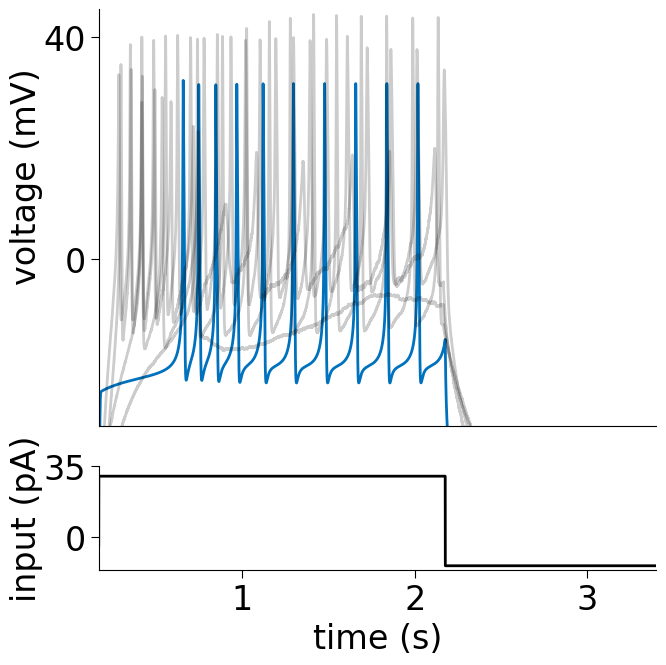

In [31]:
aike_time = np.linspace(0, 4.3, len(aike))
fig = plt.figure(figsize=(7, 7))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
# plt.plot(aike_time, aike + 5, color =[0,0.447,0.741], lw = 2, label='posterior sample')
plt.plot(aike_time,aike, color =[0,0.447,0.741],lw = 2)

plt.plot(na_free[:,0], na_free[:,1], lw = 2, color = 'k', alpha=0.2)
plt.plot(na_free[:,2], na_free[:,3], lw = 2, color = 'k', alpha=0.2)
plt.plot(na_free[:,4], na_free[:,5], lw = 2, color = 'k', alpha=0.2)
plt.plot(na_free[:,6], na_free[:,7], lw = 2, color = 'k', alpha=0.2)
plt.xlim([0.167, 3.4])
# plt.legend(loc='upper right', fontsize=16)
plt.ylabel("voltage (mV)")
# plt.title("The amplitude of the input current is %s pA" % int(I_current_amplitude[0]))
plt.setp(ax, xticks=[], yticks=[-40, 0, 40])
plt.ylim([-30, 45])
ax.yaxis.set_label_coords(-0.1, 0.6)

syn_current, duration = bp.inputs.section_input(values=[-4, I_current_amplitude, -14.],
                                             durations=[start_time, end_time - start_time, total_time - end_time],
                                             return_length=True,
                                             dt=0.1)


ax = plt.subplot(gs[1])
plt.plot(aike_time, syn_current[:,0] , "k", lw=2)
plt.xlabel("time (s)")
plt.ylabel("input (pA)")
ax.set_xlim([0.167, 3.4])
# ax.set_xticks([0, max(aike_time) / 2, max(aike_time)])
ax.set_yticks([0, np.max(syn_current[:,0]) +5])
ax.yaxis.set_label_coords(-0.1, 0.5)
plt.savefig("Figure/muscle_cell_kr_free_sim.svg", dpi = 300)

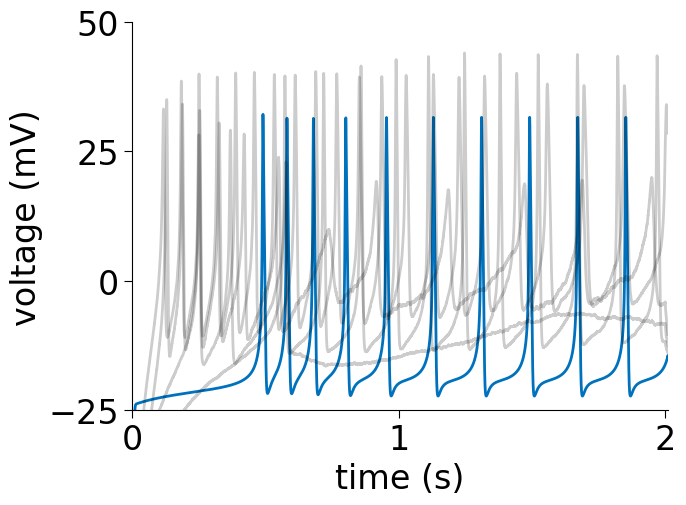

In [59]:
# 假设您已经有了变量 aike 和 na_free
aike_time = np.linspace(0, 4.3, len(aike))

# 创建图形
fig = plt.figure(figsize=(7.2, 5.4))

# 由于只需要一个子图，可以直接使用 plt.subplot()
ax = plt.subplot(111)

start_time = 0.167
time_duration = 2.
# 绘制电压曲线
plt.plot(aike_time - start_time, aike, color=[0, 0.447, 0.741], lw=2)
plt.plot(na_free[:, 0] - start_time, na_free[:, 1], lw=2, color='k', alpha=0.2)
plt.plot(na_free[:, 2] - start_time, na_free[:, 3], lw=2, color='k', alpha=0.2)
plt.plot(na_free[:, 4] - start_time, na_free[:, 5], lw=2, color='k', alpha=0.2)
plt.plot(na_free[:, 6] - start_time, na_free[:, 7], lw=2, color='k', alpha=0.2)

# 设置坐标轴范围和标签
plt.xlim([0., 2.01])
plt.ylim([-20, 45])
plt.ylabel("voltage (mV)")
plt.xlabel("time (s)")  # 添加时间轴标签
plt.setp(ax, yticks=[-25, 0, 25, 50])
plt.setp(ax, xticks=[0, 1, 2])
# ax.yaxis.set_label_coords(-0.1, 0.6)

# 保存图形
plt.savefig("Figure/muscle_cell_kr_free_sim.svg", dpi=300)
plt.show()

In [25]:
np.where(syn_current[1671:,0]<0)

(array([20099, 20100, 20101, ..., 41326, 41327, 41328]),)

In [26]:
20099 + 1671

21770